### Test augmentation for YOLO v5-v8

In this Notebook I'm testing how to create augmentated images (for example: with rotation) generating the new image and the rotated BB

I'm going to use Albumentations, see: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [1]:
from os import path
import glob
import cv2
import albumentations as A
import matplotlib.pyplot as plt

%matplotlib inline

#### Supporting functions for working with BB and YOLO BB

In [2]:
from common_functions import read_bb, write_bb, yolo_to_cv2, do_check

In [3]:
DATASET_BASE_DIR = "/Users/lsaetta/Progetti/yolo_augmentations/yolo_dataset/train"
# under this dir I have images and labels

images_list = sorted(glob.glob(path.join(DATASET_BASE_DIR, "images/*.jpg")))
labels_list = sorted(glob.glob(path.join(DATASET_BASE_DIR, "labels/*.txt")))

INDEX = 0

image_path = images_list[INDEX]
label_path = labels_list[INDEX]

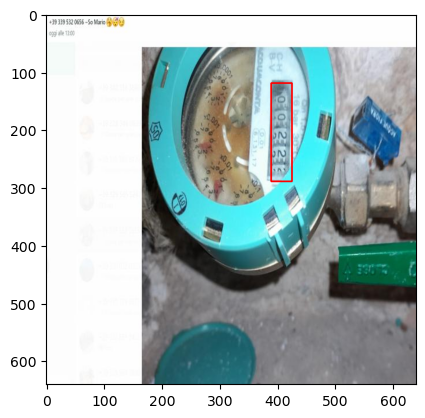

In [4]:
# Visualize image with BB

img = cv2.imread(image_path)

# consider that cv2 is using BGR we need to convert for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# read bb
yolo_bb_list = read_bb(label_path)

# the global bb is the last one
idh, idw, _ = img.shape
l, r, t, b = yolo_to_cv2(yolo_bb_list[-1], idh, idw)

color = (255, 0, 0)  # red
tickness = 2
# using copy because I want to reatin img without bb
img_rgb_bb = cv2.rectangle(img_rgb.copy(), (l, t), (r, b), color, tickness)

# show image with BB
plt.imshow(img_rgb_bb);

#### define an Albumentations Transform

see: https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/

In [5]:
transform = A.Compose(
    [A.Rotate(limit=90), A.HorizontalFlip(p=0.5)],
    bbox_params=A.BboxParams(format="yolo"),
)

####  Apply transform and show the results with the transformed BB

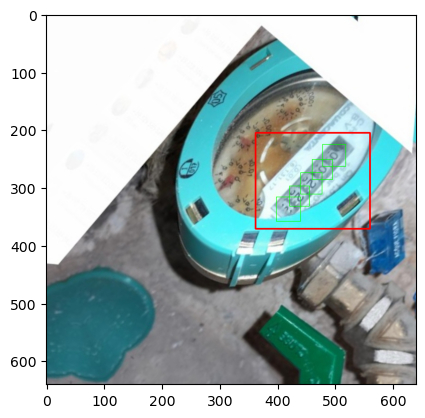

In [10]:
# all bb transforms
# every time we re-execute this cell we will get a different rotated image
# but with correctly trasformed bb (check also the green bb)

transformed = transform(image=img_rgb, bboxes=yolo_bb_list)
transformed_image = transformed["image"]
transformed_bboxes = transformed["bboxes"]

# we take here only the global bb, that is the last one
# check that it is really the last one
assert transformed_bboxes[-1][4] == 10

new_image = transformed_image.copy()
dh, dw, _ = new_image.shape

n_boxes = len(transformed_bboxes)

for i, transformed_bb in enumerate(transformed_bboxes):
    l, r, t, b = yolo_to_cv2(transformed_bb, dh, dw)

    # we show only the global BB in red to avoid messing the image
    if i == n_boxes - 1:
        color = (255, 0, 0)  # red
        tickness = 2
    else:
        color = (0, 255, 0)
        tickness = 1

    new_image = cv2.rectangle(new_image, (l, t), (r, b), color, tickness)

plt.imshow(new_image);

#### Finally, We can do some formal checks

In [11]:
do_check(yolo_bb_list, transformed_bboxes)

print("All check have been correctly verified !")

All check have been correctly verified !


#### Write the new labels

In [12]:
# write the new image
# before writing back to bgr
img_bgr = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
cv2.imwrite("./test1.jpg", img_bgr)

# write new labels
write_bb("./test1.txt", transformed_bboxes)

#### now check that image and BB are matching

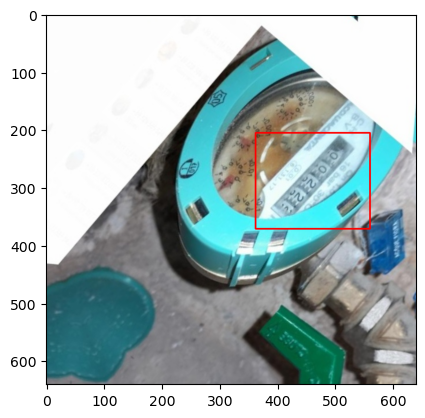

In [13]:
img = cv2.imread("./test1.jpg")

# consider that cv2 is using BGR we need to convert for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# read bb
yolo_bb_list = read_bb("./test1.txt")

# the global bb is the last one
idh, idw, _ = img.shape
l, r, t, b = yolo_to_cv2(yolo_bb_list[-1], idh, idw)

color = (255, 0, 0)  # red
tickness = 2
# using copy because I want to reatin img without bb
img_rgb_bb = cv2.rectangle(img_rgb.copy(), (l, t), (r, b), color, tickness)

# show image with BB
plt.imshow(img_rgb_bb);